## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [16]:
import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from architecture.fno_cnn_1d import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import LinearOperator #, gmres
from operators.stokes_operator import StokesAdjointBoundaryOp
import torch.nn as nn
import time
from boundary_solvers.geometry_torch import *
from architecture.session import egeofno_ver2, svdfno_ver2, svdfno_ver1, svdfno_ver3


net_dir = "/mnt/data0/emastr/article_training_nodecay/"
MESH_PATH = "/home/emastr/deep-micro-slip-model/data/mesh/"
figures_dir = "/home/emastr/deep-micro-slip-model/data/figures/"
simulation_dir = "/home/emastr/deep-micro-slip-model/data/stokes_fenics/"
data_dir = "/home/emastr/deep-micro-slip-model/data/micro_geometries_boundcurv_repar_256_torch/data_big_clean.torch"

## Create data loader

Load and transform the data. 

In [17]:
device = "cpu" # "cuda:0"
# Standard features (coordinates, derivatives of parameterisation)

num_pts = 256
full_data = torch.load(data_dir)
M = 200

data_in_dict = {full_data['info']['in_ch'][i]: full_data['X'][:M, i] for i in range(len(full_data['info']['in_ch']))}
data_out_dict = {full_data['info']['out_ch'][i]: full_data['Y'][:M, i] for i in range(len(full_data['info']['out_ch']))}

X_gmres = torch.concatenate((data_in_dict['inter_precomp_r'][:M, None], data_in_dict['inter_precomp_i'][:M, None]), dim=1)
Y_gmres = torch.concatenate((data_out_dict['precomp_r'][:M, None], data_out_dict['precomp_i'][:M, None]), dim=1)
# Reduced features (trust fourier transform to handle the rest)
#features = {'x', 'y', 'vx', 'vy'}


#Y_gmres = Y_gmres[:, :, ::s]
#X_gmres = X_gmres[:, :, ::s]
print(X_gmres.shape)
print(list(data_in_dict.keys()))
print(list(data_out_dict.keys()))


torch.Size([200, 2, 256])
['zr', 'zi', 'dzr', 'dzi', 'ddzr', 'ddzi', 'inter_precomp_r', 'inter_precomp_i', 'inter_precomp_der_r', 'inter_precomp_der_i', 'w', 't']
['precomp_r', 'precomp_i', 'precomp_der_r', 'precomp_der_i']


Create network

In [18]:
net2 = svdfno_ver3(device=device)
net2_data = torch.load(f"{net_dir}svdfno_ver3_seed0_40000.Torch", map_location=torch.device(device))
net2.load_state_dict(net2_data["state dict"])
net_settings =  {"num_pts": num_pts, "input_features": net2_data["settings"]["input_features"], "device": device, "dtype": torch.float}
net_data_set = GeomData(data_dir, net2_data["settings"]["input_features"], net2_data["settings"]["output_features"], random_roll=False, device=device, dtype=torch.float32)
X_net2 = net_data_set.X[:M].to(torch.float32)
Y_net2 = net_data_set.Y[:M].to(torch.float32)


net = egeofno_ver2(device=device)
net_data = torch.load(f"{net_dir}fno_ver2_seed0_40000.Torch", map_location=torch.device(device))
net.load_state_dict(net_data["state dict"])

net_settings =  {"num_pts": num_pts, "input_features": net_data["settings"]["input_features"], "device": device, "dtype": torch.float}
net_data_set = GeomData(data_dir, net_data["settings"]["input_features"], net_data["settings"]["output_features"], random_roll=False, device=device, dtype=torch.float32)
X_net = net_data_set.X[:M].to(torch.float32)
Y_net = net_data_set.Y[:M].to(torch.float32)

print(net_data["settings"]["output_features"])

['rt', 'rn', 'drt_norm', 'drn_norm']


Do training

Compare to GMRES

In [19]:
from util import gmres

# Create a forward operator
def op_factory(inp):
    Z   = inp['zr']   + 1j * inp['zi']
    dZ  = inp['dzr']  + 1j * inp['dzi']
    ddZ = inp['ddzr'] + 1j * inp['ddzi']
    W = inp['w']
    a = torch.ones(Z.shape[0],) * 0.5 * 1j
    return StokesAdjointBoundaryOp(Z, dZ, ddZ, W, a)

op_test = op_factory(data_in_dict)

In [20]:
from util.gmres import gmres
from torch import tensordot as dot
from torch.linalg import vector_norm as norm

class gmresNet(nn.Module):
    def __init__(self, steps, callback=None, verbose=False):
        super().__init__()
        self.steps = steps
        self.callback = callback
        self.verbose = verbose
        
        
    def forward(self, x, ops):
        y = torch.zeros_like(x)
        for n in range(x.shape[0]):
            y[n, :] = gmres(lambda x: ops(x, n), x[None, n, :], 
                            steps=self.steps, 
                            callback=self.callback, 
                            verbose=self.verbose)
        return y


In [21]:
# print(V_test.shape)
#ops = [lambda x: torch.cat([op_test(x[r].view(1, C, M), idx=[n]).view(1, C*M) 
                            #for r in range(x.shape[0])], dim=0) for n in range(N)]
# x is shape (C, M) -> 
ops =[]
K = op_test.K
(N, C, M) = X_gmres.shape
op = lambda x, n, s: x + dot(x.view(x.shape[0], C, M//s), K[n, :, :, ::s, ::s]*s, [[1,2],[1,3]]).view(x.shape[0], C*(M//s))

X_gmres_view = X_gmres.view(N, C*M)
X_gmres_view = X_gmres_view.to(torch.float64)

            
#n2 = 10
#print(f"{norm(ops[n](Y_test[None, 11].view(1, C*M)).view(1, C, M) - V_test[None, 11])},{n}")
#callback = lambda *args: print(f"{norm(opnx(Y_test[None, n2].view(1, C*M),n2).view(1, C, M) - V_test[None, n2]):.2e}")
resnet = gmresNet(steps=20)
op_sample = lambda X, s: resnet(X[:,:,::s].view(N, C*(M//s)).to(torch.float64), \
                                lambda x, n: op(x, n, s)).view(N, C, M//s)

Y_gmres = op_sample(X_gmres, 1)

In [22]:
#n = 20
t_net2 = time.time()
Y_net2_apx = net2(X_net2).detach()
t_net2 = time.time() - t_net2

t_net = time.time()
Y_net_apx = net(X_net).detach()
t_net = time.time() - t_net



We find corrupt data points by checking for outliers in the training error.

In [29]:
iters = list(range(2, 43, 3))
times = []
error = []
stride = [2, 4, 8]
for s in stride:
    print(s)
    t = time.time()
    Y_gmres_apx = op_sample(X_gmres, s)
    times.append(time.time() - t)
    error.append(np.array([norm(Y_gmres[n,:,::s] - Y_gmres_apx[n])/norm(Y_gmres[n,:,::s]) for n in range(N)]))
    
    
error3 = np.array([(norm(Y_net[n] - Y_net_apx[n])/norm(Y_net[n])).cpu() for n in range(N)])
error32 = np.array([(norm(Y_net2[n] - Y_net2_apx[n])/norm(Y_net2[n])).cpu() for n in range(N)])

error_mean = [np.mean(e) for e in error]
error3_mean = np.mean(error3)
error32_mean = np.mean(error32)

2
4
8


IndexError: list index out of range

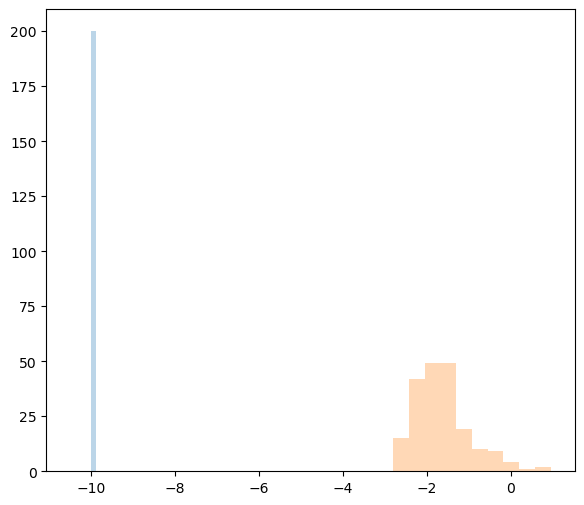

In [25]:
plt.figure(figsize=(15,6))
for i in range(0, len(iters), 2):
    plt.subplot(121)
    plt.hist(np.log10(1e-10 + error[i]), label=f'GMRES {iters[i]} iter', alpha=0.3)
    
plt.subplot(121)
plt.xlim([-9, 0])
plt.xlabel("log(norm(error))")
plt.ylabel("Probability")
plt.title("GMRES")
plt.legend()
    


Below, we compare a naive implementation of GMRES (no FMM involved), to FNO.

0.03342437744140625 0.06754279136657715


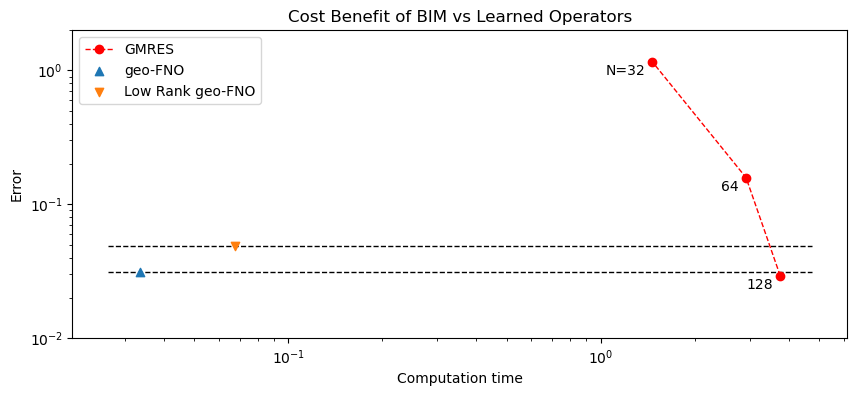

In [52]:
plt.figure(figsize=(10,4))
plt.plot(times, error_mean, 'ro--', label="GMRES", linewidth=1)
for i in range(len(times)):
    txt = f"{256//stride[i]}"
    if i == 2:
        txt = "N=" + txt
    if iters[i] != 20:
        plt.text(times[i]*0.95, (error_mean[i]+1e-10)*0.8, txt, horizontalalignment='right')

print(t_net, t_net2)
plt.scatter([t_net], [error3_mean], marker='^', label="geo-FNO")
plt.scatter([t_net2], [error32_mean], marker='v', label="Low Rank geo-FNO")
plt.yscale("log")
plt.xscale("log")
xlim = plt.gca().get_xlim()
plt.plot(xlim, [error3_mean+1e-10 for _ in range(2)], '--', color='black', linewidth=1, zorder=-2)
plt.plot(xlim, [error32_mean+1e-10 for _ in range(2)], '--', color='black', linewidth=1, zorder=-2)
plt.ylim([1e-2, 2])
#plt.gca().spines["right"].set_visible(False)
#plt.gca().spines["top"].set_visible(False)

plt.xlabel(f"Computation time")
plt.ylabel("Error")
plt.title("Cost Benefit of BIM vs Learned Operators")
plt.legend()#loc="lower left")
plt.gcf().savefig(f"{figures_dir}gmres_vs_fno.pdf")